In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import sys
import math
import glob
import os
import random
from statsmodels.stats.multitest import multipletests  
from scipy import stats
import seaborn as sns
import scipy
import statsmodels

# import classifiers
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from scipy.ndimage import gaussian_filter1d
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold

import mne
from mne.preprocessing import EOGRegression
from mne.defaults import HEAD_SIZE_DEFAULT
from mne.channels._standard_montage_utils import _read_theta_phi_in_degrees

# set root directories
root                = '/home/amber/OneDrive/code/nAdaptation_EEG_git/'

# extract eeg files
eeg_files = sorted(glob.glob(root + 'data/EEG/raw/*.bdf'))
print(eeg_files)

# extract behaviour files
behaviour_files = sorted(glob.glob(root + 'data/behaviour/raw/*.txt'))
print(behaviour_files)

# determine 
assert len(eeg_files) == len(behaviour_files) # throws error if number of eeg files doesn't match number of behavioural files
n_sub = len(eeg_files)

for i in range(len(eeg_files)):
    assert behaviour_files[i][-9:-4] == eeg_files[i][-9:-4]

# exclude subjects
exclude = []
n_sub = len(eeg_files)

print('\nNumber of subjects: ', n_sub - len(exclude))

['/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/05032024_eeg_sub20.bdf', '/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/05032024_eeg_sub21.bdf', '/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/06032024_eeg_sub22.bdf', '/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/06032024_eeg_sub23.bdf', '/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/08032024_eeg_sub24.bdf', '/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/13022024_eeg_sub01.bdf', '/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/13022024_eeg_sub02.bdf', '/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/20022024_eeg_sub04.bdf', '/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/20022024_eeg_sub06.bdf', '/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/21022024_eeg_sub07.bdf', '/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/21022024_eeg_sub08.bdf', '/home/amber/OneDrive/code/nAdaptation_EEG_git/data/EEG/raw/2202

In [2]:
# montage - creates visualization of cap when figures are plotted with mne functions
fname = root + 'config/chs.tsv'
montage = _read_theta_phi_in_degrees(fname=fname, head_size=HEAD_SIZE_DEFAULT,
                                    fid_names=['Nz', 'LPA', 'RPA'],
                                    add_fiducials=False)

# set reference electrodes
reference       = ['EMGL', 'EMGR']
eog             = ['EOGL', 'EOGR', 'EOGT', 'EOGB']
exc             = ['EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp']

In [3]:
# settings
tmin                = -0.1
tmax                = 1
sample_rate         = 2048
down_sample_rate    = 256

# band-pass frequencies
f_low       = 0.1           # high-pass filter
f_high      = 30            # low-pass filter

f_notch     = 50            # notch filter

# targets
targets                 = [3, 6, 8, 9]
n_targets               = len(targets)

# bootstrap
CI                  = 95
CI_low              = 50 - (0.5*CI)
CI_high             = 50 + (0.5*CI)
B_repetitions       = 1000

# set timepoints
if down_sample_rate == 64:
    n_timepoints            = math.floor((abs(tmin) + tmax)/(1/down_sample_rate))
else:
    n_timepoints            = math.ceil((abs(tmin) + tmax)/(1/down_sample_rate))
t                       = np.arange(n_timepoints)*(1/down_sample_rate)+tmin
print(len(t))

# channel info
n_channels      = 64

global channel_names # (e.g. Oz, Fp1) will be added later in the loop over subjects

# number of repetitions
n_repeats_clean                 = 100
n_repeats_noisy                 = 8

# initiate dataframe
adapters                    = ['none', 'same', 'different']
adapters_color              = ['gray', 'dodgerblue', np.array([212, 170, 0])/255]

contrasts                   = ['l_contrast', 'lm_contrast', 'm_contrast', 'mh_contrast', 'h_contrast']
cmap                        = plt.cm.get_cmap('cool')
contrasts_color             = cmap(np.linspace(0, 1, len(contrasts)))

282


/tmp/ipykernel_706813/1067660611.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap                        = plt.cm.get_cmap('cool')


### Retrieve data

In [4]:
# mne.set_log_level('WARNING') # suppresses warnings from MNE (less output)

# # initiate dataframes for decoding analysis
# data_clean      = np.zeros((n_sub, n_targets, n_repeats_clean, n_channels, n_timepoints))
# data_noisy      = np.zeros((n_sub, len(adapters), len(contrasts), n_targets, n_repeats_noisy, n_channels, n_timepoints))

# # retrieve data
# for iS in range(n_sub):
# # for iS in range(1):

#     print('Subject ', iS+1, '...')

#     # import behaviour file
#     df_behaviour_current = pd.read_csv(behaviour_files[iS])

#     # import raw data
#     raw = mne.io.read_raw_bdf(eeg_files[iS], eog=eog, misc=reference, exclude=exc, preload=True)
#     channel_names = raw.info['ch_names'][:n_channels]

#     # reference signal to mastoids
#     raw.set_eeg_reference(reference)

#     # apply band-pass and notch filter
#     raw.notch_filter(freqs=(f_notch))
#     raw.filter(l_freq=f_low, h_freq=f_high)

#     # set electrode montage
#     raw.set_montage(montage)

#     # find all events
#     events = mne.find_events(raw)

#     ######################### CLEAN
#     ##############################################################
#     ##############################################################

#     # sort trials in the order they were presented
#     df_behaviour_sorted = df_behaviour_current.sort_values('trial_order')

#     # select data rows
#     idx = df_behaviour_sorted[(df_behaviour_sorted.trial_type == 'clean')].index
#     df_behaviour_sorted = df_behaviour_sorted.loc[idx, :]
#     df_behaviour_sorted.reset_index(drop=True, inplace=True)
#     trigger_num = df_behaviour_sorted.loc[:, 'trigger_num'].unique().tolist()
#     # print(df_behaviour_sorted)

#     # select noisy events
#     events_noisy = mne.pick_events(events, include=trigger_num)

#     # create epochs
#     if down_sample_rate == None:
#         epochs = mne.Epochs(raw, events_noisy, baseline=(tmin, 0), picks=['eeg', 'eog'], tmin=tmin, tmax=tmax, preload='True')
#     else:
#         epochs = mne.Epochs(raw, events_noisy, baseline=(tmin, 0), picks=['eeg', 'eog'], tmin=tmin, tmax=tmax, preload='True').resample(down_sample_rate, npad='auto')

#     # transform to current source density (CSD) - noisy
#     epochs_clean_plain_csd = mne.preprocessing.compute_current_source_density(epochs)

#     for iT, target in enumerate(targets):

#         # extract noisy images
#         index = df_behaviour_sorted[(df_behaviour_sorted.target_class == target)].index
#         # print(len(index))

#         # rerieve data (events x channels x timepoints)
#         data_current = epochs_clean_plain_csd.get_data(picks=channel_names)
#         data_clean[iS, iT, :, :, :] = data_current[index, :, :]

#     ######################### NOISY
#     ##############################################################
#     ##############################################################

#     # sort trials in the order they were presented
#     df_behaviour_sorted = df_behaviour_current.sort_values('trial_order')

#     # select data rows
#     idx = df_behaviour_sorted[((df_behaviour_sorted.trial_type == 'repeated') | (df_behaviour_sorted.trial_type == 'single')) & (df_behaviour_sorted.img_type == 'test')].index
#     df_behaviour_sorted = df_behaviour_sorted.loc[idx, :]
#     df_behaviour_sorted.reset_index(drop=True, inplace=True)
#     trigger_num = df_behaviour_sorted.loc[:, 'trigger_num'].unique().tolist()
#     # print(df_behaviour_sorted)

#     # select noisy events
#     events_noisy = mne.pick_events(events, include=trigger_num)

#     # create epochs
#     if down_sample_rate == None:
#         epochs = mne.Epochs(raw, events_noisy, baseline=(tmin, 0), picks=['eeg', 'eog'], tmin=tmin, tmax=tmax, preload='True')
#     else:
#         epochs = mne.Epochs(raw, events_noisy, baseline=(tmin, 0), picks=['eeg', 'eog'], tmin=tmin, tmax=tmax, preload='True').resample(down_sample_rate, npad='auto')

#     # transform to current source density (CSD) - noisy
#     epochs_clean_plain_csd = mne.preprocessing.compute_current_source_density(epochs)

#     for iA, adapter in enumerate(adapters):
#         for iC, contrast in enumerate(contrasts):
#             for iT, target in enumerate(targets):

#                 # extract noisy images
#                 if adapter == 'none':
#                     index = df_behaviour_sorted[(df_behaviour_sorted.trial_type == 'single') & (df_behaviour_sorted.contrast == contrast) & (df_behaviour_sorted.target_class == target)].index
#                 else:
#                     index = df_behaviour_sorted[(df_behaviour_sorted.trial_type == 'repeated') & (df_behaviour_sorted.adapter == adapter) & (df_behaviour_sorted.contrast == contrast) & (df_behaviour_sorted.target_class == target)].index
#                 # print(len(index))
        
#                 # rerieve data (events x channels x timepoints)
#                 data_current = epochs_clean_plain_csd.get_data(picks=channel_names)
#                 data_noisy[iS, iA, iC, iT, :, :, :] = data_current[index, :, :]

# # clean images
# np.save(root + 'data/EEG/decoding_clean_data_256Hz', data_clean)

# # noisy images
# np.save(root + 'data/EEG/decoding_noisy_data_256Hz', data_noisy)


In [5]:
# clean images
data_clean = np.load(root + 'data/EEG/decoding_clean_data_256Hz.npy')

# noisy images
data_noisy = np.load(root + 'data/EEG/decoding_noisy_data_256Hz.npy')


## Decode clean images

Training classifier

In [6]:
# number of splits for k-fold cross validation
n_split     = 10

# initiate dataframe
decoding_accu_clean = np.ones((n_sub, n_timepoints)) * 0.25

# sliding window
window_clean      = 10
print('Time window: ', np.round(2*window_clean*(1/down_sample_rate)*1000, 2), 'ms')

# avarege over n trials
clean_trial_avg       = 1

# average every n trials
data_clean_avg      = np.zeros((n_sub, n_targets, int(n_repeats_clean/clean_trial_avg), n_channels, n_timepoints))
for iR in range(int(n_repeats_clean/clean_trial_avg)):
    start = iR*clean_trial_avg
    data_clean_avg[:, :, iR, :, :] = data_clean[:, :, start:start+clean_trial_avg, :, :].mean(2)

# create labels
df = pd.DataFrame(columns=['target', 'repeats'])
for iT, target in enumerate(targets):
    for iR in range(int(n_repeats_clean/clean_trial_avg)):
        df.loc[len(df), :] = [target, int(n_repeats_clean/clean_trial_avg)]
print(len(df))

for iS in range(n_sub):
# for iS in range(5):

    print('Current subject: ', iS+1)

    for tmp in range(window_clean, n_timepoints):

        # select data
        if window_clean == 0:
            current_data = data_clean_avg[iS, :, :, :, tmp]
        else:
            current_data = data_clean_avg[iS, :, :, :, tmp-window_clean:tmp+window_clean].mean(3)
        current_data = current_data.reshape(current_data.shape[0]*current_data.shape[1], current_data.shape[2])

        # cross-validation
        kf = KFold(n_splits=n_split, shuffle=True)

        # store accuracies for current split
        accu_current_split = list()
        for k, (train_index, test_index) in enumerate(kf.split(current_data, df.loc[:, 'target'].tolist())):

            # initiate classifier
            clf = clf = svm.SVC()

            # fit
            X_train     = current_data[train_index, :]
            X_test      = current_data[test_index, :]

            # train classifier
            clf.fit(X_train, df.loc[train_index, 'target'].tolist())

            # predict
            pred = clf.predict(X_test)

            # save accuracy
            accu_current_split.append((pred == df.loc[test_index, 'target'].tolist()).sum()/len(df.loc[test_index, 'target'].tolist()))

        # save accuracy     
        decoding_accu_clean[iS, tmp] = np.mean(accu_current_split)

Time window:  78.12 ms
400
Current subject:  1
Current subject:  2
Current subject:  3
Current subject:  4
Current subject:  5
Current subject:  6
Current subject:  7
Current subject:  8
Current subject:  9
Current subject:  10
Current subject:  11
Current subject:  12
Current subject:  13
Current subject:  14
Current subject:  15
Current subject:  16
Current subject:  17
Current subject:  18
Current subject:  19
Current subject:  20
Current subject:  21


In [7]:
# store p-values
p_values_adjust_clean = np.ones(n_timepoints)

# testing
for tmp in range(window_clean, n_timepoints):

    # parametric
    results = stats.ttest_1samp(decoding_accu_clean[:, tmp], 0.25)
    p_values_adjust_clean[tmp] = results[1]

# MC correction
p_values_adjust_sign_clean = multipletests(p_values_adjust_clean, method='sidak')[1]
# print(p_values_adjust_sign_clean)
p_values_adjust_sign_clean = np.argwhere(p_values_adjust_sign_clean < 0.05).flatten()
print(len(p_values_adjust_sign_clean))

119


/home/amber/anaconda3/envs/eeg/lib/python3.8/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


In [8]:
# # initiate figure
# fig = plt.figure()
# ax = plt.gca()

# # plot decoding accuracies
# data_mean = np.mean(decoding_accu_clean[:, :], 0)
# data_std = np.std(decoding_accu_clean[:, :], 0)/math.sqrt(n_sub)

# # plot data
# # ax.plot(t, decoding_accu_clean.T, color='dodgerblue', lw=0.5)
# ax.plot(t, data_mean)
# ax.fill_between(t, data_mean - data_std, data_mean + data_std, alpha=0.2)

# # adjust axes
# ax.axhline(1/len(targets), linestyle='dotted', color='grey')
# ax.axvline(0, lw=0.5, color='grey', zorder=-10)
# ax.axhline(0, lw=0.5, color='grey', zorder=-10)
# ax.set_ylim(0.2, 0.35)
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Decoding accuracy')
# ax.legend(frameon=False)

# # plot stats
# ax.scatter(t[p_values_adjusted_sign_clean], np.ones(len(p_values_adjusted_sign_clean))*0.22, s=10, color='grey')

# plt.title('clean trials (n = ' + str(n_sub) + ')')
# plt.tight_layout()
# plt.savefig(dir + 'visualizations/decoding/decoding_performance', dpi=300)

## Decode noisy images

In [9]:
# sliding window
window_noisy      = 10
print('Time window: ', np.round(2*window_noisy*(1/down_sample_rate)*1000, 2), 'ms')

# intiate dataframe to store decoding accuracies
decoding_accu_noisy       = np.ones((n_sub, len(adapters), len(contrasts), n_timepoints)) * 0.25

# initiate dataframe
adapters                    = ['none', 'same', 'different']
contrasts                   = ['l_contrast', 'lm_contrast', 'm_contrast', 'mh_contrast', 'h_contrast']

# avarege over n trials
noisy_trial_avg       = 1
print(n_repeats_noisy/noisy_trial_avg)

# average every n trials
data_noise_avg      = np.zeros((n_sub, len(adapters), len(contrasts), n_targets, int(n_repeats_noisy/noisy_trial_avg), n_channels, n_timepoints))
for iR in range(int(n_repeats_noisy/noisy_trial_avg)):
    start = iR*noisy_trial_avg
    data_noise_avg[:, :, :, :, iR, :, :] = data_noisy[:, :, :, :, start:start+noisy_trial_avg, :, :].mean(4)

# initiate dataframe
df = pd.DataFrame(columns=['adapter', 'contrast', 'target', 'repeats'])

# add data
for iA, adapter in enumerate(adapters):
    for iC, contrast in enumerate(contrasts):
        for iT, target in enumerate(targets):
            for iR in range(int(n_repeats_noisy/noisy_trial_avg)):
                df.loc[len(df), :] = [adapter, contrast, target, iR+1]
print(len(df))

for iS in range(n_sub):
# for iS in range(1):

    # print progress
    print('Current subject: ', iS+1)

    for tmp in range(window_noisy, n_timepoints):

        # select data
        if window_noisy == 0:
            current_data = data_noise_avg[iS, :, :, :, :, :, tmp]
        else:
            current_data = data_noise_avg[iS, :, :, :, :, :, tmp-window_noisy:tmp+window_noisy].mean(5)
        current_data = current_data.reshape(current_data.shape[0]*current_data.shape[1]*current_data.shape[2]*current_data.shape[3], current_data.shape[4])
        # print(current_data.shape)

        for iA, adapter in enumerate(adapters):
            for iC, contrast in enumerate(contrasts):

                # initiate classifier
                clf = clf = svm.SVC()

                # select train and test indices
                test_index = df[(df.adapter == adapter) & (df.contrast == contrast)].index                
                train_index = [num for num in np.arange(len(df)) if num not in test_index]
                            
                # select data
                X_train = current_data[train_index, :]
                X_test = current_data[test_index, :]
                
                # fit classifier
                clf.fit(X_train, df.loc[train_index, 'target'].tolist())

                # predict
                pred = clf.predict(X_test)

                # # save accuracy
                decoding_accu_noisy[iS, iA, iC, tmp] = (pred == df.loc[test_index, 'target']).sum()/len(df.loc[test_index, 'target'])

Time window:  78.12 ms
8.0
480
Current subject:  1
Current subject:  2
Current subject:  3
Current subject:  4
Current subject:  5
Current subject:  6
Current subject:  7
Current subject:  8
Current subject:  9
Current subject:  10
Current subject:  11
Current subject:  12
Current subject:  13
Current subject:  14
Current subject:  15
Current subject:  16
Current subject:  17
Current subject:  18
Current subject:  19
Current subject:  20
Current subject:  21


In [10]:
# store p-values
p_values_adjust_noisy = np.ones(n_timepoints)

# testing
for tmp in range(window_noisy, n_timepoints):

    # parametric
    results = stats.ttest_1samp(decoding_accu_noisy[:, :, :, tmp].mean(1).mean(1), 0.25)
    p_values_adjust_noisy[tmp] = results[1]

# MC correction
p_values_adjust_sign_noisy = multipletests(p_values_adjust_noisy, method='sidak')[1]
p_values_adjust_sign_noisy = np.argwhere(p_values_adjust_sign_noisy < 0.05).flatten()
print(len(p_values_adjust_sign_noisy))

3


/home/amber/anaconda3/envs/eeg/lib/python3.8/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


In [11]:
# # initiate figure
# fig = plt.figure()
# ax = plt.gca()

# # select data
# data_current = decoding_accu_noisy[:, :, :, :].mean(1).mean(1)

# # plot decoding accuracies
# data_mean = np.mean(data_current, 0)
# data_std = np.std(data_current, 0)/math.sqrt(n_sub)

# # plot data
# ax.plot(t, data_mean)
# ax.fill_between(t, data_mean - data_std, data_mean + data_std, alpha=0.2)

# # plot stats
# ax.scatter(t[p_values_adjust_sign_noisy], np.ones(len(p_values_adjust_sign_noisy))*0.22, s=10, color='grey')

# # adjust axes
# ax.axhline(1/len(targets), linestyle='dotted', color='grey', label='Chance level')
# ax.axvline(0, lw=0.5, color='grey', zorder=-10)
# ax.axhline(0, lw=0.5, color='grey', zorder=-10)
# ax.set_ylim(0.2, 0.35)
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Decoding accuracy')
# ax.legend(frameon=False)

# plt.suptitle('clean trials (n = ' + str(n_sub) + ')')
# plt.tight_layout()
# plt.savefig(dir + 'visualizations/decoding/decoding_performance_adapter', dpi=300)

## Visualize

/tmp/ipykernel_706813/224407437.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap                = plt.cm.get_cmap('Blues')
/tmp/ipykernel_706813/224407437.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap                = plt.cm.get_cmap('YlOrBr')


Mean decoding accuracy - clean:  0.27996649558026804
STD decoding accuracy - clean:  0.007331752662784102
Clean:  119  significant timepoints
4
0.0001773049645390071
none :  0  significant timepoints
4
0.0001773049645390071
same :  80  significant timepoints
4
0.0001773049645390071
different :  31  significant timepoints
F_onewayResult(statistic=7.02418347149778, pvalue=0.00029800054111096054)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.013     0.283    -0.006     0.031
 (0 - 2)      0.016     0.097    -0.002     0.035
 (0 - 3)      0.032     0.000     0.013     0.050
 (1 - 0)     -0.013     0.283    -0.031     0.006
 (1 - 2)      0.004     0.948    -0.015     0.022
 (1 - 3)      0.019     0.036     0.001     0.038
 (2 - 0)     -0.016     0.097    -0.035     0.002
 (2 - 1)     -0.004     0.948    -0.022     0.015
 (2 - 3)      0.015     0.130    -0.003     0.034
 (3 - 0)     -0.032     0.000    -0

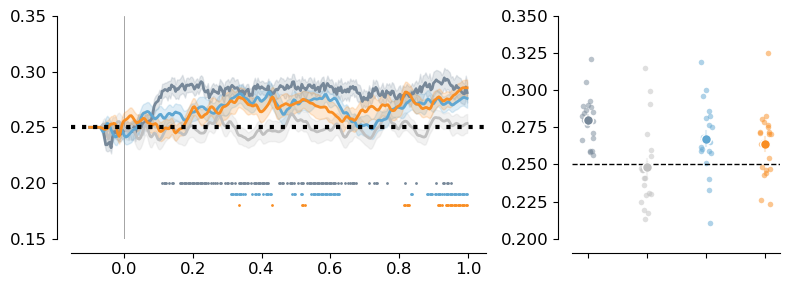

In [68]:
from scipy.stats import f_oneway

t_start     = np.argwhere(t > 0)[0][0]
t_end       = np.argwhere(t > 0.65)[0][0]

# initiate figure
fig, axs = plt.subplots(1, 2, figsize=(8, 3), width_ratios=[2, 1])

# settings for plotting
sns.despine(offset=10)

fontsize_title          = 18
fontsize_legend         = 12
fontsize_label          = 14
fontsize_tick           = 12

sigma   = 0.5
spread  = 0.01

cmap                = plt.cm.get_cmap('Blues')
color_same          = cmap(np.linspace(0.3, 1, 4))

# color_diff          = plt.cm.get_cmap('tab20b')
# color_diff          = color_diff.colors[8:11]
cmap                = plt.cm.get_cmap('YlOrBr')
color_diff          = cmap(np.linspace(0.3, 1, 4))

adapters_color  = ['silver', color_same[1], color_diff[1]]

lw  = 2
s   = 2

######################## FULL contrast TIMECOURSES
color = 'lightslategray'

# select data
data_current = decoding_accu_clean

print('Mean decoding accuracy - clean: ', np.mean(data_current[:, t_start:t_end]))
print('STD decoding accuracy - clean: ', np.std(data_current[:, t_start:t_end])/math.sqrt(n_sub))

# plot decoding accuracies
data_mean = gaussian_filter1d(np.mean(data_current, 0), sigma)
data_std = np.std(data_current, 0)/math.sqrt(n_sub)

# plot data
axs[0].plot(t, data_mean, color=color, label='clean', lw=lw)
axs[0].fill_between(t, data_mean - data_std, data_mean + data_std, color=color, alpha=0.2)

# plot stats
axs[0].scatter(t[p_values_adjust_sign_clean], np.ones(len(p_values_adjust_sign_clean))*0.2, s=1, color=color)#, transform=ax.transAxes)
print('Clean: ', len(t[p_values_adjust_sign_clean]), ' significant timepoints')

# save average accuracy
avg_dacc = np.zeros((n_sub, len(adapters)+1))

######################## FULL contrast AVG
color = 'lightslategray'

# select data
avg_dacc[:, 0] = decoding_accu_clean[:, t_start:t_end].mean(1)

# plot decoding accuracies
data_mean = np.mean(avg_dacc[:, 0])
data_std = np.std(avg_dacc[:, 0])/math.sqrt(n_sub)

# plot data
axs[1].scatter(-1, data_mean, color=color, edgecolor='white', s=50)
axs[1].plot([-1, -1], [data_mean - data_std, data_mean + data_std], color=color, alpha=0.2)

# plot individual subjects
sns.stripplot(x=np.ones(n_sub)*-1, y=avg_dacc[:, 0], jitter=True, ax=axs[1], color=color, size=4, alpha=0.5, native_scale=True, legend=False, zorder=-10)

# visualize
for iA, adapter in enumerate(adapters):

    if adapter == 'same':
        pos = 1
    elif adapter == 'different':
        pos = 2
    elif adapter == 'none':
        pos = 0

    ############################################ PLOT TIMECOURSES

    # select data
    data_current = gaussian_filter1d(decoding_accu_noisy[:, iA, :, :].mean(1), sigma)

    # plot decoding accuracies
    data_mean = gaussian_filter1d(np.mean(data_current, 0), 1)
    data_std = gaussian_filter1d(np.std(data_current, 0)/math.sqrt(n_sub), 1)

    # plot data
    axs[0].plot(t, data_mean, color=adapters_color[iA], label=adapter, lw=lw)
    axs[0].fill_between(t, data_mean - data_std, data_mean + data_std, color=adapters_color[iA], alpha=0.2)

    # store p-values
    p_values_adjust_noisy = np.ones(n_timepoints)

    # testing
    for tmp in range(window_noisy, n_timepoints):

        # parametric
        results = stats.ttest_1samp(data_current[:, tmp], 0.25)
        p_values_adjust_noisy[tmp] = results[1]

    # FDR correction
    p_values_adjust_sign_noisy = multipletests(p_values_adjust_noisy, method='fdr_bh')
    print(len(p_values_adjust_sign_noisy))
    print(p_values_adjust_sign_noisy[3])
    p_values_adjust_sign_noisy = np.argwhere(p_values_adjust_sign_noisy[1] < 0.05).flatten()

    axs[0].scatter(t[p_values_adjust_sign_noisy], np.ones(len(p_values_adjust_sign_noisy))*0.2+spread-spread*(iA+1), s=1, color=adapters_color[iA])

    print(adapter, ': ', len(t[p_values_adjust_sign_noisy]), ' significant timepoints')

    ############################################ PLOT AVG

    # select data
    avg_dacc[:, iA+1] = decoding_accu_noisy[:, iA, :, t_start:t_end].mean(2).mean(1)

    # plot decoding accuracies
    data_mean = np.mean(avg_dacc[:, iA+1])
    data_std = np.std(avg_dacc[:, iA+1])/math.sqrt(n_sub)

    # plot data
    axs[1].scatter(pos, data_mean, color=adapters_color[iA], edgecolor='white', s=50, label=adapter)
    axs[1].plot([pos, pos], [data_mean - data_std, data_mean + data_std], color=adapters_color[iA], alpha=0.2)

    # plot individual subjects
    sns.stripplot(x=np.ones(n_sub)*pos, y=avg_dacc[:, iA+1], jitter=True, ax=axs[1], color=adapters_color[iA], size=4, alpha=0.5, native_scale=True, legend=False, zorder=-10)

# adjust axes
axs[0].tick_params(axis='both', labelsize=fontsize_tick)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].axhline(1/len(targets), linestyle='dotted', color='black', lw=3, label='Chance level')
axs[0].axvline(0, lw=0.5, color='grey', zorder=-10)
axs[0].axhline(0, lw=0.5, color='grey', zorder=-10)
axs[0].set_ylim(0.15, 0.35)
# axs[0].set_xlabel('Time (s)', fontsize=fontsize_label)
# axs[0].set_ylabel('Decoding accuracy', fontsize=fontsize_label)

axs[1].tick_params(axis='both', labelsize=fontsize_tick)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xticks(np.arange(len(adapters)+1)-1)
axs[1].set_xticklabels([' ', ' ', ' ', ' '], fontsize=fontsize_label, rotation=45, ha="right")
# axs[1].set_ylabel('Decoding accuracy', fontsize=fontsize_label)
axs[1].axhline(0.25, lw=1, linestyle='dashed', color='black', zorder=-10)
axs[1].set_ylim(0.20, 0.35)

# one-way anova
results = f_oneway(avg_dacc[:, 0], avg_dacc[:, 2], avg_dacc[:, 3], avg_dacc[:, 1])
print(results)
results = tukey_hsd(avg_dacc[:, 0], avg_dacc[:, 2], avg_dacc[:, 3], avg_dacc[:, 1])
print(results)

for i in range(4):

        # parametric
        results = stats.ttest_1samp(avg_dacc[:, i], 0.25)
        print(results)

# plt.suptitle('clean trials (n = ' + str(n_sub) + ')')
plt.tight_layout()
plt.savefig(root + 'visualization/Fig8A', dpi=300)
plt.savefig(root + 'visualization/Fig8A.svg')

(21, 3, 5, 282)
(21, 282)
(21, 282)


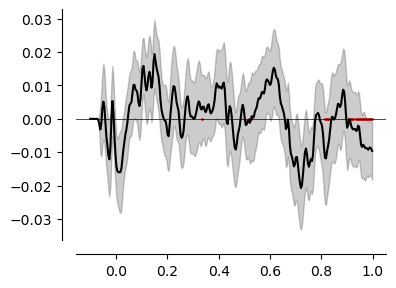

In [55]:
# initiate figure
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

# settings for plotting
sns.despine(offset=10)

fontsize_title          = 15
fontsize_legend         = 10
fontsize_label          = 12
fontsize_tick           = 10

############################################ PLOT TIMECOURSES

# select data
print(decoding_accu_noisy.shape)
data_current_same = decoding_accu_noisy[:, 1, :, :].mean(1)
print(data_current_same.shape)
data_current_diff = decoding_accu_noisy[:, 2, :, :].mean(1)
print(data_current_diff.shape)

# compute different
diff = data_current_same - data_current_diff

# # plot decoding accuracies
data_mean = gaussian_filter1d(np.mean(diff, 0), 1)
data_std = gaussian_filter1d(np.std(diff, 0)/math.sqrt(n_sub), 1)

# plot data
ax.plot(t, data_mean, color='black', label=adapter)
ax.fill_between(t, data_mean - data_std, data_mean + data_std, color='black', alpha=0.2)

# store p-values
p_values_adjust_noisy = np.ones(n_timepoints)

# testing
for tmp in range(window_noisy, n_timepoints):

    # parametric
    results = stats.ttest_1samp(diff[:, tmp], 0)
    p_values_adjust_noisy[tmp] = results[1]


ax.axhline(0, lw=0.5, color='black')
ax.scatter(t[p_values_adjust_sign_noisy], np.ones(len(p_values_adjust_sign_noisy))*0, s=1, color='red')
# print(p_values_adjust_noisy)


adapter

/tmp/ipykernel_706813/3252966476.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap                = plt.cm.get_cmap('Blues')
/tmp/ipykernel_706813/3252966476.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap                = plt.cm.get_cmap('YlOrBr')


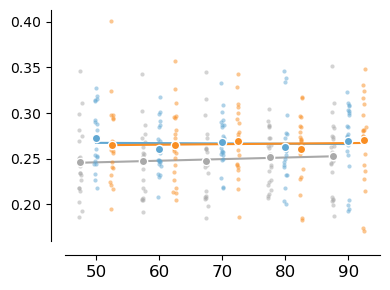

In [13]:
from scipy.stats import f_oneway
from scipy.stats import tukey_hsd

# initiate figure
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

# settings for plotting
sns.despine(offset=10)

fontsize_title          = 15
fontsize_legend         = 10
fontsize_label          = 12
fontsize_tick           = 10

# create strings for subject
subject_str = []
for i in range(n_sub):
    subject_str.append('sub' + str(i+1))

# initiate dataframe
df_stats = pd.DataFrame()
df_stats['subject'] = np.tile(subject_str, len(adapters)*len(contrasts))
df_stats['contrast'] = np.repeat(contrasts, len(adapters)*(n_sub))
df_stats['adapter'] = np.tile(np.repeat(adapters, n_sub), len(contrasts))
df_stats['dependentVar'] = 0
# print(df_stats)

# time window
t_start     = np.argwhere(t > 0)[0][0]
t_end       = np.argwhere(t > 0.99)[0][0]

# colors
cmap                = plt.cm.get_cmap('Blues')
color_same          = cmap(np.linspace(0.3, 1, 4))

# color_diff          = plt.cm.get_cmap('tab20b')
# color_diff          = color_diff.colors[8:11]
cmap                = plt.cm.get_cmap('YlOrBr')
color_diff          = cmap(np.linspace(0.3, 1, 4))

adapters_color  = ['darkgrey', color_same[1], color_diff[1]]

# adapter typoe
adapters_plot = ['none', 'same', 'different']

# offset adapter wrt x-axis
offset_iC = np.array([0, 4, 8, 12, 16])
offset_iA = [-1, 0, 1]

# visualize
for iA, adapter in enumerate(adapters):

    # ############################################ PLOT CONTRAST

    # select data
    data_current = decoding_accu_noisy[:, iA, :, t_start:t_end].mean(2)

    # plot decoding accuracies
    data_mean = np.mean(data_current, 0)
    data_std = np.std(data_current, 0)/math.sqrt(n_sub)

    # plot data
    # axs[1].bar(offset_iC+offset_iA[iA], data_mean, color=adapters_color[iA], edgecolor='white', label=adapter)
    ax.scatter(offset_iC+offset_iA[iA], data_mean, color=adapters_color[iA], edgecolor='white', label=adapter)

    # plot individual subjects
    for iC, contrast in enumerate(contrasts):

        # visualize
        axs[1].plot([offset_iC[iC]+offset_iA[iA], offset_iC[iC]+offset_iA[iA]], [data_mean[iC] - data_std[iC], data_mean[iC] + data_std[iC]], color=adapters_color[iA])
        sns.stripplot(x=np.ones(n_sub)*offset_iC[iC]+offset_iA[iA], y=data_current[:, iC], jitter=True, ax=ax, color=adapters_color[iA], size=3, alpha=0.5, native_scale=True, legend=False, zorder=-10)

        # add to dataframe
        idx = df_stats[(df_stats.contrast == contrast) & (df_stats.adapter == adapter)].index
        df_stats.loc[idx, 'dependentVar'] = data_current[:, iC]

    # fit regression
    pred = np.zeros((n_sub, len(contrasts)))
    for iS in range(n_sub):
        model = scipy.stats.linregress(np.arange(len(contrasts)), data_current[iS, :])
        pred[iS, :] = model.intercept + model.slope * np.arange(len(contrasts))
    ax.plot(np.array(offset_iC)+offset_iA[iA], np.mean(pred, 0), color=adapters_color[iA], zorder=-10)

    # adjust axes
    ax.tick_params(axis='both', labelsize=fontsize_tick)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(offset_iC)
    ax.set_xticklabels(['50', '60', '70', '80', '90'], fontsize=fontsize_label)
    # ax.set_ylabel('Decoding accuracy', fontsize=fontsize_label)
    # ax.set_xlabel('Contrast (%)', fontsize=fontsize_label)
    # ax.axhline(0.25, linestyle='dotted', color='black', lw=1, zorder=-10)

plt.tight_layout()
plt.savefig(root + 'visualization/Fig8B', dpi=300)
plt.savefig(root + 'visualization/Fig8B.svg')

contrast